In [2]:
from pathlib import Path

import polars as pl
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import get_project_root
from src.swinno_helpers import connect_swinno_db

ROOT = get_project_root()
con = connect_swinno_db()

In [3]:
query = """
select
  i.sinno_id,
  i.innovation_name_in_swedish AS name,
  i.description_in_swedish AS description,
  i.additional_information_if_origin_new_scientific_discovery || i.additional_information_if_origin_new_technologies_or_materials || i.additional_info_if_origin_official_regulation_legislation_and_standards || i.additional_information_if_origin_solution_for_a_problem || i.additional_information_if_origin_performance || i.additional_information_if_origin_other AS info,
  i.year_of_commercialization AS year,
  us.use_sector
from
  innovation i
  join use_sectors us on i.sinno_id = us.sinno_id
where
  (
    us.use_sector like '02%'
    or us.use_sector like '20%'
    or us.use_sector like '21%'
    or us.use_sector like '36%'
    or product_code like '02%'
    or product_code like '20%'
    or product_code like '21%'
    or product_code like '36%'
  )
  or (
    description like '%virke%'
    or description like '%cellulos%'
    or description like '%lignin%'
    or description like '%spån%'
    or description like '%bark%'
    or description like '%levulinsyra%'
    or description like '%furfural%'
    or description like '%svarttjära%'
    or description like '%svartlut%'
    or description like '%växtbas%'
    or description like '%ved%'
    or description like '%trä%'
    or description like '%skog%'
    or description like '%biobränsle%'
    or description like '%biologisk%'
    or description like '%nedbrytbar%'
    or description like '%papper%'
    or description like '%pappret%'
    or description like '%karton%'
    or description like '%tencel%'
  )
    and i.sinno_id not in (SELECT cn.sinno_id from categorization_notes AS cn WHERE cn.notes LIKE "%not forest%")
;
"""



In [4]:

bioeconomy_counts = pl.read_database(query, con).select(pl.col(["sinno_id", "year"])).group_by("year").n_unique().sort(by="year").rename({"sinno_id":"counts"})

<AxesSubplot: xlabel='year', ylabel='counts'>

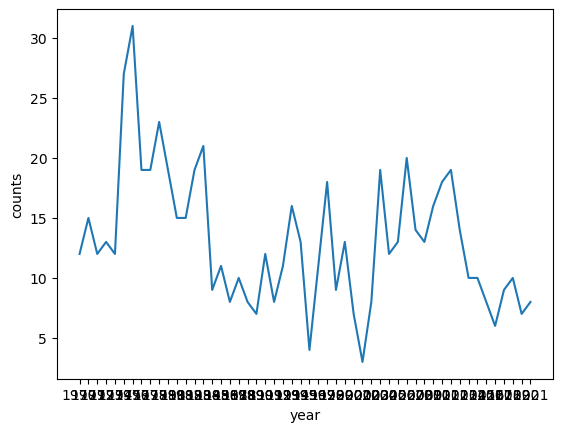

In [5]:
sns.lineplot(x="year", y="counts", data=bioeconomy_counts)

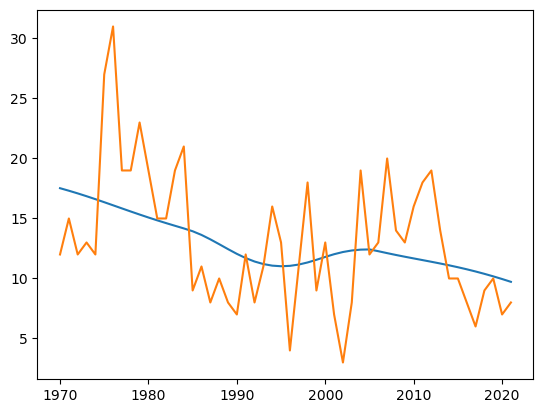

In [6]:
smoothed= lowess(endog=bioeconomy_counts["counts"], exog=bioeconomy_counts["year"])

plt.plot(smoothed[:, 0], smoothed[:, 1])
plt.plot(smoothed[:, 0], bioeconomy_counts["counts"])

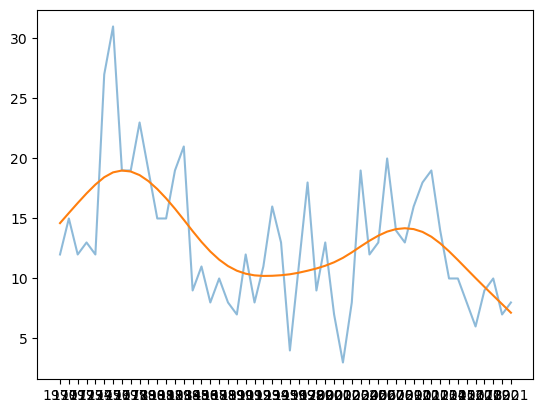

In [19]:
import statsmodels.api as sm

cycle, trend = sm.tsa.filters.hpfilter(bioeconomy_counts["counts"], lamb=200)


plt.plot(bioeconomy_counts["year"], bioeconomy_counts["counts"], alpha=0.5)
plt.plot(bioeconomy_counts["year"], trend)

In [8]:
bioeconomy_counts.plot(x="year", y="counts")

:Curve   [year]   (counts)

In [20]:
import numpy as np

def hamilton_filter(data, h, p=None):
    r"""
    This function applies "Hamilton filter" to the data

    http://econweb.ucsd.edu/~jhamilto/hp.pdf

    Parameters
    ----------
    data : array or dataframe
    h : integer
        Time horizon that we are likely to predict incorrectly.
        Original paper recommends 2 for annual data, 8 for quarterly data,
        24 for monthly data.
    p : integer (optional)
        If supplied, it is p in the paper. Number of lags in regression.
        If not supplied, random walk process is assumed.

    Returns
    -------
    cycle : array of cyclical component
    trend : trend component

    Notes
    -----
    For seasonal data, it's desirable for p and h to be integer multiples of
    the number of obsevations in a year. E.g. for quarterly data, h = 8 and p =
    4 are recommended.

    """
    # transform data to array
    y = np.asarray(data, float)
    # sample size
    T = len(y)

    if p is not None:  # if p is supplied
        # construct X matrix of lags
        X = np.ones((T-p-h+1, p+1))
        for j in range(1, p+1):
            X[:, j] = y[p-j:T-h-j+1:1]

        # do OLS regression
        b = np.linalg.solve(X.transpose()@X, X.transpose()@y[p+h-1:T])
        # trend component (`nan` for the first p+h-1 period)
        trend = np.append(np.zeros(p+h-1)+np.nan, X@b)
        # cyclical component
        cycle = y - trend
    else:  # if p is not supplied (random walk)
        cycle = np.append(np.zeros(h)+np.nan, y[h:T] - y[0:T-h])
        trend = y - cycle
    return cycle, trend


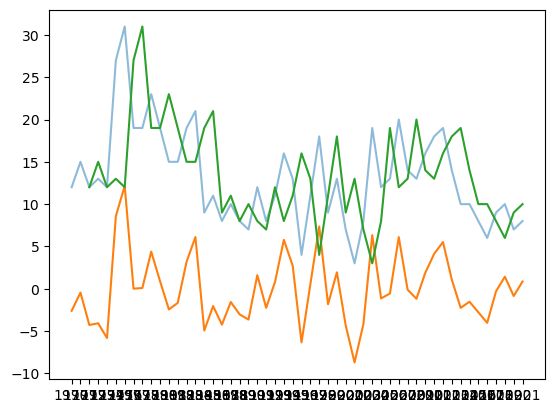

In [45]:
cylce, trend = hamilton_filter(bioeconomy_counts.to_numpy()[:,1], h=2)

plt.plot(bioeconomy_counts["year"], bioeconomy_counts["counts"], alpha=0.5)
plt.plot(bioeconomy_counts["year"], cycle)
plt.plot(bioeconomy_counts["year"], trend)